In [ ]:
whe%cd /content/drive/MyDrive/Medical-Image-Segmentation/Code/data-science-bowl-2018

/content/drive/MyDrive/Medical-Image-Segmentation/Code/data-science-bowl-2018


# Imports and Function Definitions

In [ ]:
from collections import Counter
import os 
import random 
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm 
import datetime
import matplotlib.pyplot as plt
import pickle

from skimage.io import imread as sk_imread, imshow as sk_imshow
from skimage.transform import resize as sk_resize

import cv2

import tensorflow as tf
from tensorflow import keras
%load_ext tensorboard

In [ ]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

#Data Paths
TRAIN_PATH = 'data_custom/train/'
VAL_PATH = 'data_custom/val/'
TEST_PATH = 'data_custom/test/'

TRAIN_IDS = [x[:-4] for x in os.listdir(TRAIN_PATH +'images')]
VAL_IDS = [x[:-4] for x in os.listdir(VAL_PATH +'images')]
TEST_IDS = [x[:-4] for x in os.listdir(TEST_PATH +'images')]

print('example id:', TRAIN_IDS[0])
print('*'*50)
print('number of train instances', len(TRAIN_IDS))
print('number of val instances', len(VAL_IDS))
print('number of test instances', len(TEST_IDS))

example id: 0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed
**************************************************
number of train instances 669
number of val instances 65
number of test instances 3019


In [ ]:
def get_id_path(id, data='train', type='image'):
  """Get the absolute path of image/mask from the id.
     In parameters, specify it ifs the mask or image 
     and whether if its from training or validation or testing data"""
  if type == 'image':
    return 'data_custom/' + data + '/images/' + id + '.png' 
  elif type == 'mask':
    return 'data_custom/' + data + '/masks/' + id + '.png'
  else: 
    print('enter valid type ("image" or "mask")')

def get_id_image(id, data='train'):
  """input: id of image 
     output: its array form"""
  path = get_id_path(id, data=data, type='image')
  return sk_imread(path)

def get_id_mask(id, data='train'):
  """input: id of image
     output: true mask of image id in form of numpy array"""
  path = get_id_path(id, data=data, type='mask')
  return sk_imread(path)

# Preparing train and test data

Deciding the shape for the network

In [ ]:
shapes = []
for id in tqdm(TRAIN_IDS):
  shapes.append(get_id_image(id).shape[:2])
  
print('Different shapes found')
Counter(shapes)

  0%|          | 0/669 [00:00<?, ?it/s]

Different shapes found


Counter({(256, 256): 334,
         (256, 320): 112,
         (260, 347): 4,
         (360, 360): 91,
         (512, 640): 13,
         (520, 696): 92,
         (603, 1272): 6,
         (1024, 1024): 16,
         (1040, 1388): 1})

* Input shape we are choosing as 256, 256 since its the most common and the smallest in resolution. Number of channels we will use as 3 since  every image (apart from one in test set) is found in RGB/RGBA.

In [ ]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 3

Checking the resize function

(256, 320, 4)


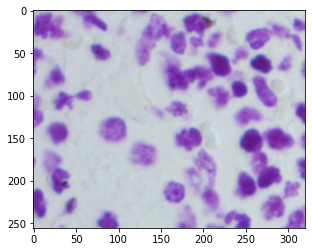

(256, 256, 4)


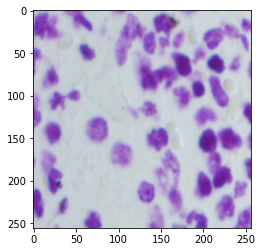

In [ ]:
sample_img = get_id_image(TRAIN_IDS[0])
print(sample_img.shape)
plt.imshow(sample_img)
plt.show()
sample_resized = cv2.resize(sample_img, (IMG_WIDTH, IMG_HEIGHT))
print(sample_resized.shape)
plt.imshow(sample_resized)
plt.show()

* Note that cv2.resize takes arguments as (width, height) and not (height, width)
* Also it keeps the values as integers only. 

#### Saving the data

In [ ]:
flag = False

if flag:
  #TRAIN
  X_train = np.zeros((len(TRAIN_IDS), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)).astype('uint8')
  for i, id in tqdm(enumerate(TRAIN_IDS), total=len(TRAIN_IDS)): 
    img = get_id_image(id, 'train')
    #taking care of grayscale image if any
    if np.ndim(img) == 2:
      img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    #RGBA to RGB
    img = img[:,:,:IMG_CHANNELS]
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    X_train[i] = img

  y_train = np.zeros((len(TRAIN_IDS), IMG_HEIGHT, IMG_WIDTH, 1)).astype('uint8')
  for i, id in tqdm(enumerate(TRAIN_IDS), total=len(TRAIN_IDS)): 
    mask = get_id_mask(id, 'train')
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
    y_train[i] = mask[:,:,np.newaxis]

  ########################################################################################
  #VALIDATION
  X_val = np.zeros((len(VAL_IDS), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)).astype('uint8')
  for i, id in tqdm(enumerate(VAL_IDS), total=len(VAL_IDS)): 
    img = get_id_image(id, 'val')
    #taking care of grayscale image if any
    if np.ndim(img) == 2:
      img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    #RGBA to RGB
    img = img[:,:,:IMG_CHANNELS]
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    X_val[i] = img

  y_val = np.zeros((len(VAL_IDS), IMG_HEIGHT, IMG_WIDTH, 1)).astype('uint8')
  for i, id in tqdm(enumerate(VAL_IDS), total=len(VAL_IDS)): 
    mask = get_id_mask(id, 'val')
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
    y_val[i] = mask[:,:,np.newaxis]

  ########################################################################################
  #TEST
  X_test = np.zeros((len(TEST_IDS), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)).astype('uint8')
  for i, id in tqdm(enumerate(TEST_IDS), total=len(TEST_IDS)): 
    img = get_id_image(id, 'test')
    #taking care of grayscale image if any
    if np.ndim(img) == 2:
      img = np.repeat(img[:, :, np.newaxis], 3, axis=2)
    #RGBA to RGB
    img = img[:,:,:IMG_CHANNELS]
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    X_test[i] = img

In [ ]:
flag = False
if flag:   
  y_train = y_train / 255.0
  y_val = y_val / 255.0

  y_train = np.round(y_train).astype('uint8')
  y_val = np.round(y_val).astype('uint8')

In [ ]:
flag = False
if flag:
  with open('tensors/X_train','wb') as f: pickle.dump(X_train, f)
  with open('tensors/X_val','wb') as f: pickle.dump(X_val, f)
  with open('tensors/X_test','wb') as f: pickle.dump(X_test, f, protocol=4)
  with open('tensors/y_train','wb') as f: pickle.dump(y_train, f)
  with open('tensors/y_val','wb') as f: pickle.dump(y_val, f)

* X_train, X_val and X_test contain pixel values from 0 to 255. y_train and y_val pixels are normalized and binarized (they are 1 or 0)

# Sanity Check 

In [ ]:
with open('tensors/X_train','rb') as f: X_train = pickle.load(f)
with open('tensors/X_val','rb') as f: X_val = pickle.load(f)
with open('tensors/X_test', 'rb') as f: X_test = pickle.load(f)
with open('tensors/y_train','rb') as f: y_train = pickle.load(f)
with open('tensors/y_val','rb') as f: y_val = pickle.load(f)

In [ ]:
print(X_train.dtype)
print(X_val.dtype)
print(X_test.dtype)
print(y_train.dtype)
print(y_val.dtype)

uint8
uint8
uint8
uint8
uint8


In [ ]:
print('train data shape', X_train.shape, y_train.shape)
print('val data shape', X_val.shape, y_val.shape)
print('test data shape', X_test.shape)

train data shape (669, 256, 256, 3) (669, 256, 256, 1)
val data shape (65, 256, 256, 3) (65, 256, 256, 1)
test data shape (3019, 256, 256, 3)


In [ ]:
print(np.max(X_train), np.min(X_train))
print(np.max(X_val), np.min(X_val))
print(np.max(X_test), np.min(X_test))

255 0
255 0
255 0


In [ ]:
print(np.unique(y_train))
print(np.unique(y_val))

[0 1]
[0 1]


In [ ]:
temp_df = pd.DataFrame(np.zeros(len(X_train)))
temp_x = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2]*X_train.shape[3]))
temp_df['mean_pixel'] = np.mean(temp_x, axis=1)
temp_df['max_pixel'] = np.max(temp_x, axis=1)
temp_df['min_pixel'] = np.min(temp_x, axis=1)
temp_df.describe()

,0,mean_pixel,max_pixel,min_pixel
count,669.0,669.000000,669.000000,669.000000
mean,0.0,43.754777,165.563528,6.754858
std,0.0,64.875623,73.471475,9.462010
min,0.0,0.964401,29.000000,0.000000
25%,0.0,8.880920,102.000000,1.000000
50%,0.0,13.765808,173.000000,3.000000
75%,0.0,24.687164,236.000000,10.000000
max,0.0,217.882568,255.000000,63.000000


In [ ]:
temp_df = pd.DataFrame(np.zeros(len(X_val)))
temp_x = X_val.reshape((X_val.shape[0], X_val.shape[1]*X_val.shape[2]*X_val.shape[3]))
temp_df['mean_pixel'] = np.mean(temp_x, axis=1)
temp_df['max_pixel'] = np.max(temp_x, axis=1)
temp_df['min_pixel'] = np.min(temp_x, axis=1)
temp_df.describe()

,0,mean_pixel,max_pixel,min_pixel
count,65.0,65.000000,65.000000,65.000000
mean,0.0,53.745555,206.876923,4.476923
std,0.0,68.153962,65.968626,6.149461
min,0.0,3.493896,71.000000,0.000000
25%,0.0,12.728394,160.000000,0.000000
50%,0.0,22.385986,254.000000,1.000000
75%,0.0,51.148132,255.000000,9.000000
max,0.0,218.552429,255.000000,29.000000


#### Visual Checking 

In [ ]:
for i in range(len(TRAIN_IDS)):
  print(i, '->', TRAIN_IDS[i])
  fig, axes = plt.subplots(1, 4, figsize=(16, 12))
  ax = axes.ravel()
  ax[0].imshow(get_id_image(TRAIN_IDS[i], 'train'))
  ax[1].imshow(X_train[i])
  ax[2].imshow(get_id_mask(TRAIN_IDS[i], 'train'), cmap='gray')
  ax[3].imshow(y_train[i][:,:,0], cmap='gray')
  fig.tight_layout()
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for i in range(len(VAL_IDS)):
  print(i, '->', VAL_IDS[i])
  fig, axes = plt.subplots(1, 4, figsize=(16, 12))
  ax = axes.ravel()
  ax[0].imshow(get_id_image(VAL_IDS[i], 'val'))
  ax[1].imshow(X_val[i])
  ax[2].imshow(get_id_mask(VAL_IDS[i], 'val'), cmap='gray')
  ax[3].imshow(y_val[i][:,:,0], cmap='gray')
  fig.tight_layout()
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

* We see that there are random human errors in mask annotation. These are random errors hence shouldnt hurt training. Eg. 

 94 -> 220b37f4ca7cab486d2b71cd87a46ee7411a5aa142799d96ed98015ab5ba538a

 241 -> 58c593bcb98386e7fd42a1d34e291db93477624b164e83ab2afa3caa90d1d921